This notebook is mostly to take a look at the data, and to figure what kinds of things are described in it.

In [2]:
from pyspark.sql import SparkSession, functions as F


def get_spark():
    return SparkSession.builder.config("spark.local.dir", "/mnt/data/tmp").getOrCreate()


spark = get_spark()
spark

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/29 22:03:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/09/29 22:03:46 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in standalone/kubernetes and LOCAL_DIRS in YARN).
25/09/29 22:03:47 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
df = spark.read.csv(
    "/home/anthony/scratch/ai4animals/sensor_eda/AcTBeCalf.csv",
    header=True,
    inferSchema=True,
).cache()
df.show()

+--------------------+------+--------+--------+---------+--------------------+-----+
|            dateTime|calfId|    accX|    accY|     accZ|           behaviour|segId|
+--------------------+------+--------+--------+---------+--------------------+-----+
|2022-02-24 00:08:...|  1306|  0.8125|0.390625|  0.28125|oral_manipulation...|    0|
|2022-02-24 00:08:...|  1306|  0.6875|   0.375|    0.375|oral_manipulation...|    0|
|2022-02-24 00:08:...|  1306|   0.625|0.296875| 0.265625|oral_manipulation...|    0|
|2022-02-24 00:08:...|  1306|0.703125| 0.21875|  0.21875|oral_manipulation...|    0|
|2022-02-24 00:08:...|  1306|0.734375| 0.21875|     0.25|oral_manipulation...|    0|
|2022-02-24 00:08:...|  1306|    0.75|0.234375|     0.25|oral_manipulation...|    0|
|2022-02-24 00:08:...|  1306|  0.9375|  0.3125| 0.171875|oral_manipulation...|    0|
|2022-02-24 00:08:...|  1306|0.890625|0.328125|     0.25|oral_manipulation...|    0|
|2022-02-24 00:08:...|  1306|0.703125|   0.375|  0.15625|oral_man

In [4]:
df.printSchema()

root
 |-- dateTime: timestamp (nullable = true)
 |-- calfId: integer (nullable = true)
 |-- accX: double (nullable = true)
 |-- accY: double (nullable = true)
 |-- accZ: double (nullable = true)
 |-- behaviour: string (nullable = true)
 |-- segId: integer (nullable = true)



In [5]:
df.describe().show()

25/09/29 22:03:58 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+-------------------+--------------------+---------+------------------+
|summary|            calfId|              accX|               accY|                accZ|behaviour|             segId|
+-------+------------------+------------------+-------------------+--------------------+---------+------------------+
|  count|           2467162|           2467162|            2467162|             2467162|  2467162|           2467162|
|   mean|1363.3675279531706|0.7037010414192502|-0.1383766360397088|0.025851128492981004|     NULL|1860.2866086620984|
| stddev|55.239441894211105|0.4324866287756599|0.36701529521784776| 0.40316721879492157|     NULL| 1176.876765203122|
|    min|              1302|          -5.65625|          -7.765625|              -3.625|      SRS|                 0|
|    max|              1455|          7.859375|            6.59375|             6.59375|  walking|              4015|
+-------+------------------+------------------+---------

In [6]:
# number of calves
df.select("calfId").distinct().count()

30

In [7]:
# number of behavios
behaviours = df.groupBy("behaviour").count().orderBy("count", ascending=False)
behaviours.show()
print(behaviours.count())


+--------------------+------+
|           behaviour| count|
+--------------------+------+
|               lying|965184|
|       drinking_milk|217075|
|            standing|188908|
| eating_concentrates|146067|
|               sniff|134768|
|      eating_bedding|129119|
|oral_manipulation...|118210|
|            grooming|114181|
|             running| 83345|
|       eating_forage| 80428|
|             walking| 67337|
|        social_groom| 29776|
|        social_sniff| 23019|
|            headbutt| 17819|
|    rumination_lying| 16794|
|      grooming_lying| 12175|
|       sniff_walking| 11347|
|            abnormal| 10903|
|             scratch| 10306|
|              social|  9185|
+--------------------+------+
only showing top 20 rows
50


In [8]:
df.groupBy("behaviour").agg(F.count("segId").alias("num_segments")).orderBy(
    "num_segments", ascending=False
).show()


+--------------------+------------+
|           behaviour|num_segments|
+--------------------+------------+
|               lying|      965184|
|       drinking_milk|      217075|
|            standing|      188908|
| eating_concentrates|      146067|
|               sniff|      134768|
|      eating_bedding|      129119|
|oral_manipulation...|      118210|
|            grooming|      114181|
|             running|       83345|
|       eating_forage|       80428|
|             walking|       67337|
|        social_groom|       29776|
|        social_sniff|       23019|
|            headbutt|       17819|
|    rumination_lying|       16794|
|      grooming_lying|       12175|
|       sniff_walking|       11347|
|            abnormal|       10903|
|             scratch|       10306|
|              social|        9185|
+--------------------+------------+
only showing top 20 rows


In [9]:
# how many timepoints per segment on average
df.groupBy("calfId", "segId").count().groupBy().avg("count").show()

+-----------------+
|       avg(count)|
+-----------------+
|614.3331673306773|
+-----------------+



In [17]:
calf = 1306
display(df.where(f"calfId = {calf}").count())
df.where(f"calfId = {calf}").groupBy("segId").count().count()
df.where(f"calfId = {calf}").where("segId = 0").groupBy("behaviour").count().orderBy("count", ascending=False).show()
df.where(f"calfId = {calf}").where("segId = 1").groupBy("behaviour").count().orderBy("count", ascending=False).show()

107829

+--------------------+-----+
|           behaviour|count|
+--------------------+-----+
|oral_manipulation...|  825|
+--------------------+-----+

+--------------------+-----+
|           behaviour|count|
+--------------------+-----+
|oral_manipulation...|  557|
+--------------------+-----+



<Axes: xlabel='dateTime'>

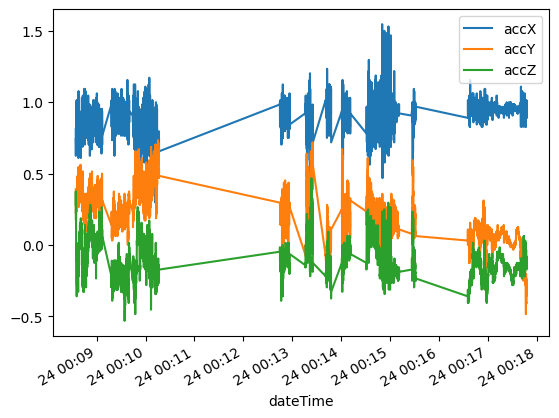

In [19]:
# how to visualize this time series data?
import matplotlib.pyplot as plt

pdf = df.where("calfId = 1306").where("segId < 10").orderBy("dateTime").toPandas()
pdf.plot(x="dateTime", y=["accX", "accY", "accZ"])

In [59]:
# what are the distances between sensor readings?
from pyspark.sql.window import Window

df.where("calfId = 1306").where("segId < 10").orderBy("dateTime").select(
    "dateTime",
    F.lag("dateTime").over(
        Window.partitionBy("calfId").orderBy("dateTime")
    ).alias("prev_time"),
    F.row_number().over(
        Window.partitionBy("calfId").orderBy("dateTime")
    ).alias("row_num"),
).select(
    # convert to seconds
    "row_num",
    ((F.unix_micros("dateTime") - F.unix_micros("prev_time")) / 1000000).alias(
        "time_diff"
    )
).where("time_diff > 0.1").show()

+-------+----------+
|row_num| time_diff|
+-------+----------+
|    826| 11.290133|
|   1383|  4.294051|
|   2201|148.289746|
|   2505| 19.038224|
|   2746| 15.787186|
|   2917| 13.135155|
|   3181| 19.786233|
|   4201| 15.544183|
|   4328| 63.801751|
+-------+----------+

